<br><br>
<font size="5">**First step: Import libraries**</font>
<br> <font size="4">(You may get some warnings about ONEDNN here. They can safely be ignored.)<font>
<br>    
<font size="4">The libraries listed here are a lot of the "usual suspects" for doing machine learning analysis with deep learning models.</font>
- <font size="4">NUMPY is the numerical python library commonly used to do linear algebra operations of various sorts.</font>
- <font size="4">PANDAS is a library designed to make manipulation of data much easier and more convenient.</font>
- <font size="4">CSV is a library for importing and exporting data in "comma-separated value" format.</font>
- <font size="4">MATPLOTLIB is a library for displaying graphs and charts.</font>
- <font size="4">SKLEARN is scikit-learn, one of the most important libraries for machine learning applications.</font>
- <font size="4">TORCH is a library for running neural network models, including deep learning models. The other major library is TENSORFLOW.</font>
- <font size="4">TRANSFORMERS, DATASETS, EVALUATE, and LOGGING are libraries provided by HuggingFace, the major place to get open source, trained deep learning models.</font>
    
<font size="4">Note that this demo is an adaptation of the following tutorial:</font><br><br>
<font size="4">Regression with Text Input Using BERT and Transformers(https://lajavaness.medium.com/regression-with-text-input-using-bert-and-transformers-71c155034b13)</font>
<br><br>


In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
from transformers import TrainingArguments
from transformers import Trainer
from datasets import Dataset
from datasets import load_metric
import evaluate
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import logging
logging.disable(logging.INFO)

<br><br>
<font size="4">**Next Step:** Set up to run BERT, one of the most popular deep learning models. It's not as powerful as the latest generation of large language models, like OpenAI's, but it's a good model to run to get a baseline.</font>
- <font size="4">BASE_MODEL specifies which HuggingFace library we're going to load. In this case, it's the base BERT model. This is a pretrained transformer model whose weights have been set to make the neural network predict what words go in what contexts.</font>
- <font size="4">LEARNING_RATE specifies how quickly the weights in the untrained part of the model will be adjusted to fine-tune the model to the task we're training it to do..</font>
- <font size="4">MAX_LENGTH is very important, and it reflects one of the limitations of the transformer model. It's the maximum number of tokens that can be processed by the model. Maximum for BERT is 512, but I set it to 256 here because on my machine (and probably most machines you're likely to have) a greater length will hit memory limitations. This means we'll only be taking the first 256 tokens of every essay. Running with 512 would improve the model, if you have the machine to do it.</font>
- <font size="4">BATCH_SIZE is the number of cases pulled and run TOGETHER during training. Larger batch sizes make for more effective learning, but take a lot more memory. 16 or 32 are the usual settings.</font>
- <font size="4">EPOCHS is how often we'll iterate through the entire training dataset. 20 is a LOT of training for fine-tuning. Normally models settle to a reasonable number in 2-4 epochs. I'm using the 20 setting here as that will give us a chance to see how the model learning process proceeds. With 20 epochs, the model might overfit, but we'll see if that's true when we run cross-validation.</font>
<br>
<br>

<font size="4">**The major other setup steps are:** </font>
- <font size="4">to set up variables that tell the model how many classes there are and what their labels are (that's id2label and label2id)</font>
- <font size="4">figure out what devices are available (a GPU, which uses the CUDA library, or just the cpu),</font>
- <font size="4">initialize the tokenizer</font>
- <font size="4">initialize the model</font>
<br>
<br>
<font size="4">Note that Autotokenizer and AutoModelForSequenceClassification are HuggingFace classes.</font>
<br>
<font size="4">(When you run this, you will get warnings basically telling you that you are initializing a model for classification that has not yet been fine-tuned. This is expected.)</font>
<br><br>


In [2]:
BASE_MODEL = "bert-base-uncased"
LEARNING_RATE = 2e-5
MAX_LENGTH = 256
BATCH_SIZE = 16
EPOCHS = 20

# Let's name the classes 0, 1, 2, 3, 4 like their indices
id2label = {k:k for k in range(6)}
label2id = {k:k for k in range(6)}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, id2label=id2label, label2id=label2id)
print('device', device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

device cuda


<br><br>
**<font size="4">Next Step: Load the ICNALE Corpus data.</font>**

<font size="4">We are using the file names from this corpus to assign CEFR levels, since most of the files code that information directly. For the spoken dialog files, which don't, we're loading a csv file that gives us the mapping to CEFR levels indirectly.</font>

- <font size="4">ICNALE_SD_CEFR_LEVELS.csv is a file taken directly from the ICNALE download. It has all the demographic and performance data about individuals who produced spoken dialogs.</font>
- <font size="4">ICNALE_DOCS.CSV is a file I produced that has all the corpus texts in one place. It only contains the file name for each text (which directly encodes much of the critical information about task and user ids and in most cases, CEFR level)</font>
- <font size="4">I am transforming CEFR levels into an ordinal scale, reflecting the levels distingushed by the ICNALE Corpus. Thus:</font>
1. <font size="4">1 = CEFR Level A2</font>
2. <font size="4">2 = CEFR Level B1_1</font>
3. <font size="4">3 = CEFR Level B1_2</font>
4. <font size="4">4 = CEFR Level B2</font>
5. <font size="4">5 = English native speakers (presumably, at levels C1 or C2)</font>
<br><br>


In [3]:
text = []
labels = []
sd_cefr_levels = {}
ds = []  

with open('ICNALE_SD_CEFR_LEVELS.csv', 'r', encoding='utf=8') as datasheet:
    for line in csv.reader(datasheet):
        if len(line)>2:
            country = line[0]
            speaker = line[1]
            level = line[2]
            sublevel = '0'
            if len(line)>3:
                sublevel = line[3]
                if country not in sd_cefr_levels:
                    sd_cefr_levels[country] = {}
                if speaker not in sd_cefr_levels[country]:
                    sd_cefr_levels[country][speaker] = [level, sublevel]
            elif country == 'ENS':
                if country not in sd_cefr_levels:
                    sd_cefr_levels[country] = {}
                sd_cefr_levels[country][speaker] = [level, sublevel]
              
with open('icnale_docs.csv', 'r', encoding='utf=8') as data:
    for line in csv.reader(data):
        index = line[0]
        index_array = index.split('_')
        if len(index_array)>2:
            entry = {}
            entry['id'] = index
            str_en = line[1].encode("ascii", "ignore")
            entry['text'] = str_en.decode()
    
            entry['score'] = 6
            if len(index_array)>5 and index_array[4] == 'A2':
                labels.append(1)
                entry['score'] = 1
            elif len(index_array)>5 and index_array[4] == 'B1' and index_array[5] == '1':
                labels.append(2)
                entry['score'] = 2
            elif len(index_array)>5 and index_array[4] == 'B1' and index_array[5] == '2':
                labels.append(3)
                entry['score'] = 3
            elif len(index_array)>5 and index_array[4] == 'B2':
                labels.append(4)
                entry['score'] = 4
            elif len(index_array)>2 and (index_array[0] == 'ENS' or index_array[1] == 'ENS'):
                labels.append(5)
                entry['score'] = 5
            else:
                if len(index_array)>2:
                  level_id = index_array[0]
                  sublevel_id = index_array[1]
                  if level_id in sd_cefr_levels and sublevel_id in sd_cefr_levels[level_id]:
                      level = sd_cefr_levels[level_id][sublevel_id][0]
                      sublevel = sd_cefr_levels[level_id][sublevel_id][1]
                      if level == 'A2':
                          labels.append(1)
                          entry['score'] = 1
                      elif level == 'B1' and sublevel == '1':
                          labels.append(2)
                          entry['score'] = 2
                      elif level == 'B1' and sublevel == '2':
                          labels.append(3)
                          entry['score'] = 3
                      elif level == 'B2':
                          entry['score'] = 4
                          labels.append(4)
                      else:
                          print('skipped', level_id, sublevel_id)
                          labels.append(-1)
                          entry['score'] = -1
                  else:
                      print('skipped', level_id, sublevel_id, sd_cefr_levels[level_id].keys())
                else:
                    print('skipped', index_array[0], index_array[1])
            text.append(line[1])
            ds.append(entry)


<br><br>
**<font size="4">Next Step: Divide the data up into training, validation, and test sets.</font>**

<font size="4">The SKLEARN library train_test_split is the usual function to use to split data into train and test sets. In this case, we apply it twice, since we're subdividing the data into </font>
- <font size="4">A TRAINING SET (used to train the deep learning model)</font>
- <font size="4">A VALIDATION SET (used to correct the deep learning model as it iterates through the training data to adjust model weights)</font>
- <font size="4">A TEST SET (held out till the end to use to evaluate the final model)</font>
<br><br>


In [4]:
val_ratio = 0.4

train, test = train_test_split(ds, test_size=val_ratio)
val, test = train_test_split(test, test_size=0.5)

raw_train_ds = Dataset.from_list(train)
raw_val_ds = Dataset.from_list(val)
raw_test_ds = Dataset.from_list(test)
final_ds = {"train": raw_train_ds, "validation": raw_val_ds, "test": raw_test_ds}


<br><br>
**<font size="4">Preprocessing Function</font>**

<font size="4">This is a function that preprocess the data into the transformer input format appropriate for BERT. It applies the tokenizer and reads in the numeric score as categorical (integer) data, since the first model we run is going to have 5 categories corresponding to the CEFR levels we're distinguishing.</font>
<br><br>


In [5]:
def preprocess_function(examples):
    label = examples["score"] 
    examples = tokenizer(examples["text"], truncation=True, padding="max_length", max_length=256)
    
    # Change this to real number
    examples["label"] = label
    return examples

for split in final_ds:
    final_ds[split] = final_ds[split].map(preprocess_function, remove_columns=["id", "text", "score"])


Map:   0%|          | 0/9457 [00:00<?, ? examples/s]

Map:   0%|          | 0/3152 [00:00<?, ? examples/s]

Map:   0%|          | 0/3153 [00:00<?, ? examples/s]

<br><br>
**<font size="4">Set up the metrics we use for model training and evaluation</font>**

<font size="4">We're using the accuracy metric defined by the HuggingFace evaluate library as the basic metric for the model. Note that the deep learning model returns a tensor that's the output of the neural network training. It has a different float value for each of the 5 possible categories we're predicting. We use the numpy argmax function to figure out which of the 5 categories is the most probable.</font>
<br><br>


In [6]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

<br><br>
**<font size="4">Display the distribution of CEFR scores in the training, validation, and test sets.</font>**

<font size="4">We're using the matplotlib library to show how the data is distributed.</font>

<font size="4">Note that the 1-5 range is CEFR levels A2, B1_1, B1_2, B2. 5 is reserved for English native speakers.</font>
<br><br>

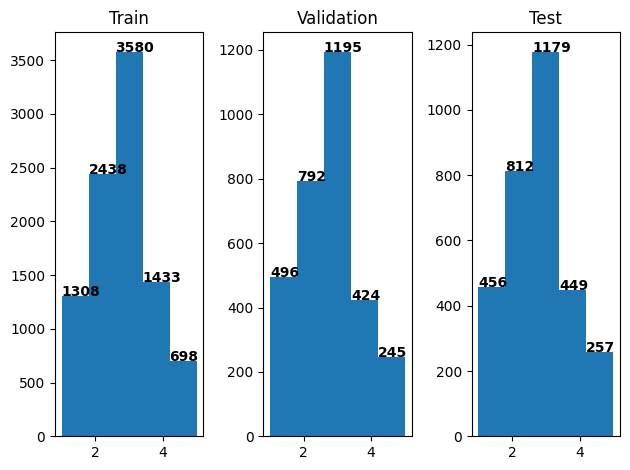

In [7]:

fig, axs = plt.subplots(1, 3, tight_layout=True)
distributions = []
axs[0].set_title("Train"); axs[1].set_title("Validation"); axs[2].set_title("Test"); 
train_distributions = axs[0].hist(raw_train_ds["score"], bins=5)
val_distributions = axs[1].hist(raw_val_ds["score"], bins=5)
test_distributions = axs[2].hist(raw_test_ds["score"], bins=5)

for distributions, ax in zip([train_distributions, val_distributions, test_distributions], axs):
    for j in range(5):
        # Display the counts on each column of the histograms
        ax.text(distributions[1][j], distributions[0][j], str(int(distributions[0][j])), weight="bold")
plt.show()


<br><br>
**<font size="4">Set up the training scheme.</font>**

<font size="4">This setup uses the HuggingFace Trainer library, which simplifies a lot of the setup for using a specific model. The settings worth taking note of here are:</font>
- <font size="4">WEIGHT_DECAY, which is a parameter of learning (basically, to keep the model from overfitting, it forgets a little as it learns)</font>
- <font size="4">METRIC_FOR_BEST_MODEL is set to accuracy, so the trainer can decide which model of all the EPOCHS is the best</font>
- <font size="4">LOAD_BEST_MODEL_AT_END is set to TRUE, which means that if the accuracy stops going up after a certain number of epochs, we'll choose an earlier epoch as the correct model if it has the best performance.</font>

<font size="4">Note that we're only using the training and validation datasets to train the model. We hold out the test data till the end.</font>


<font size="4">Note that at the very beginning of this notebook, I disabled logging. If you don't, a LOT of data gets stored off with every run, which can use up disk space surprisingly quickly.</font>
<br><br>


In [9]:
training_args = TrainingArguments(
    output_dir="../models/bert-fine-tuned-regression",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=final_ds["train"],
    eval_dataset=final_ds["validation"],
    compute_metrics=compute_metrics
)


<br><br>
**<font size="4">Run the Trainer</font>**

<font size="4">Now we do the actual fine-tuning of BERT. </font>
- <font size="4">*Loss* is the metric the neural network uses to measure how much it has learned.
The lower it is, the better.</font>
- <font size="4">Note that accuracy climbed until epoch 4, when it went up and down a bit, before stabilizing around .53 to .54. This suggests that 4 epochs would have given us decent results. But even so, the best results are at epoch 20.</font>
<br><br>

In [10]:
trainer.train()

/home/paul/miniconda3/envs/bert/lib/python3.11/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.305200,1.188022,0.472716
2,1.105900,1.182044,0.484454
3,0.956100,1.241213,0.486358
4,0.779800,1.421060,0.507614
5,0.578700,1.634333,0.498414
6,0.309600,1.721996,0.526650
7,0.231700,2.394197,0.491434
8,0.186600,2.390304,0.511104
9,0.167100,2.815800,0.522525
10,0.129700,3.133488,0.518084


TrainOutput(global_step=11840, training_loss=0.2844806824584265, metrics={'train_runtime': 3819.1986, 'train_samples_per_second': 49.523, 'train_steps_per_second': 3.1, 'total_flos': 2.488330614196224e+16, 'train_loss': 0.2844806824584265, 'epoch': 20.0})

<br><br>
**<font size="4">Evaluate the final model on the held-out test dataset</font>**

<font size="4">We get an accuracy on the test dataset around .53, which suggests that our 20 runs didn't actually overfit. This is probably about as good a model was we're going to get on this dataset. .53 isn't great for most classification tasks. It's not actually as bad as it sounds here, as we'll see when we look at the confusion matrix.</font>
<br><br>

In [11]:
trainer.eval_dataset=final_ds["test"]
trainer.evaluate()

{'eval_loss': 4.334981441497803,
 'eval_accuracy': 0.532825880114177,
 'eval_runtime': 18.3529,
 'eval_samples_per_second': 171.799,
 'eval_steps_per_second': 10.788,
 'epoch': 20.0}

<br><br>
**<font size="4">Examine the confusion matrix for this model</font>**

- <font size="4">The confusion matrix shows us that most of the errors are on adjacent CEFR levels. I.e., A2 is mostly confused with B1_1. B1_1 is mostly confused with A2 and B1_2. B1_2 is mostly confused with B1_1 and B2. ENS is mostly confused with B2.</font>
- <font size="4">This means that the accuracy is really better than .53, but the accuracy metric only cares if you get the classification exactly right. Automated scoring models on an ordinal scale, like this 1-5 scale, often have a significant percentage of adjacent classifications, even for models that are fairly good.</font>
<br><br>

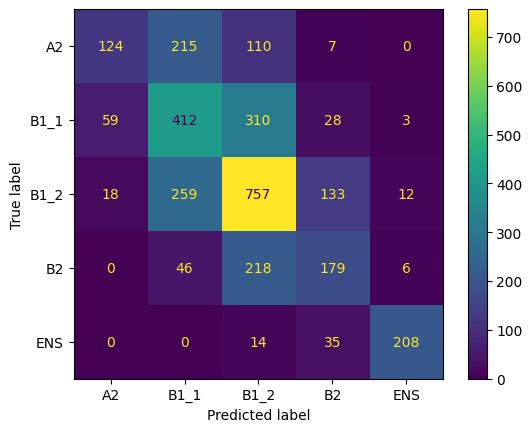

In [12]:
from sklearn import metrics

y_preds = []

for i in range(len(raw_test_ds)):
    input_texts = raw_test_ds[i]["text"]
    input_labels = raw_test_ds[i]["score"]
    encoded = tokenizer(input_texts,
                        truncation=True,
                        padding="max_length",
                        max_length=256,
                        return_tensors="pt").to("cuda")

    with torch.no_grad():
        logits = model(**encoded, return_dict=True).logits
        y_preds.append(torch.argmax(logits.to('cpu')).item())

cm = metrics.confusion_matrix(raw_test_ds['score'], y_preds)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm,
                                            display_labels = ['A2', 'B1_1', 'B1_2', 'B2', 'ENS'])

cm_display.plot()
plt.show()

<br><br>
<font size="4">For this kind of data, quadratic weighted kappa (QWK) is a metric often used. It penalizes errors more severely, the larger they are, so that (for instance) confusing ENS with B2 is penalized a lot less than confusing ENS with A2.</font>

<font size="4">I'm using the following code to calculate quadratic weighted kappa in python (https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/quadratic_weighted_kappa.py).</font>

<font size="4">We get a QWK of about .68, which is decent but not great. Ideally we'd like to see a classifier get a QWK well above .70, if we want to call it a strong model.</font>

<font size="4">So it looks like our deep learning model is performing OK, but not great. We're able to tell with reasonable certainty whether someone's a native speaker, and roughly what CEFR band the native speakers are in, but not with grat precision.</font>
<br><br>


In [13]:

def confusion_matrix2(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings

def quadratic_weighted_kappa(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Calculates the quadratic weighted kappa
    quadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.

    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.

    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.

    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix2(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return 1.0 - numerator / denominator

quadratic_weighted_kappa(raw_test_ds['score'], y_preds, 0, 6)

0.6761978114389623

<br><br>
**<font size="4">Reset model to run a regression</font>**

<font size="4">Running the fine-tuning with 5 categories makes no assumptions about the relationships among the categories. So it's possible we'd get better results by running the model as a regression. The BERT model runs a regression if we set the number of categories, to 1.</font>
<br><br>

In [14]:
BASE_MODEL = "bert-base-uncased"
LEARNING_RATE = 2e-5
MAX_LENGTH = 256
BATCH_SIZE = 16
EPOCHS = 20

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL, num_labels=1)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

<br><br>
**<font size="4">Redefine the preprocess function**</font>

<font size="4">We need the outcome variable is a float variable if we're going to run BERT as a regressor.</font>
<br><br>

In [15]:
def preprocess_function2(examples):
    label = examples["score"] 
    examples = tokenizer(examples["text"], truncation=True, padding="max_length", max_length=256)
    
    # Change this to real number
    examples["label"] = float(label)
    return examples


<br><br>
**<font size="4">Reset the data using the new reprocess function</font>**
<br><br>

In [16]:
final_ds = {"train": raw_train_ds, "validation": raw_val_ds, "test": raw_test_ds}
for split in final_ds:
    final_ds[split] = final_ds[split].map(preprocess_function2, remove_columns=["id", "text", "score"])


Map:   0%|          | 0/9457 [00:00<?, ? examples/s]

Map:   0%|          | 0/3152 [00:00<?, ? examples/s]

Map:   0%|          | 0/3153 [00:00<?, ? examples/s]

<br><br>
**<font size="4">Define metrics for regression</font>**

<font size="4">The metrics we use for regression are different than metrics we use for classification.</font>
- <font size="4">Error is predicted value minus absolute value. MSE squares that and takes the average, which penalizes more for larger errors. MAE just takes the absolute value of the error and takes the average, which doesn't penalize large errors so severely. R2 (r squared) is the correlation between predicted and true values, squared, again penalizing weaker relations between actual and predicted scores more strongly.</font>
<br><br>

In [17]:
def compute_metrics_for_regression(eval_pred):
    logits, labels = eval_pred
    labels = labels.reshape(-1, 1)
    
    mse = mean_squared_error(labels, logits)
    mae = mean_absolute_error(labels, logits)
    r2 = r2_score(labels, logits)
    single_squared_errors = ((logits - labels).flatten()**2).tolist()
    
    # Compute accuracy 
    # Based on the fact that the rounded score = true score only if |single_squared_errors| < 0.5
    accuracy = sum([1 for e in single_squared_errors if e < 0.25]) / len(single_squared_errors)
    
    return {"mse": mse, "mae": mae, "r2": r2, "accuracy": accuracy}


<br><br>
**<font size="4">Trainer setup for regression</font>**

<font size="4">Note that we're using MSE to define loss. This means that the model will be trying to minimize the mean squared error, not maximimze accuracy, during the training steps. At the end though, we pick the model with the highest accuracy.</font>
<br><br>


In [18]:
training_args = TrainingArguments(
    output_dir="../models/bert-fine-tuned-regression-2",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,
    weight_decay=0.01,
)

class RegressionTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs[0][:, 0]
        loss = torch.nn.functional.mse_loss(logits, labels)
        return (loss, outputs) if return_outputs else loss
        
trainer = RegressionTrainer(
    model=model,
    args=training_args,
    train_dataset=final_ds["train"],
    eval_dataset=final_ds["validation"],
    compute_metrics=compute_metrics_for_regression
)


<br><br>
**<font size="4">Run the trainer**</font>

<font size="4">Note that the accuracy never quite reaches the level of the classification model. 
The best model is at epoch 9, where we reach an accuracy of .51 and an R2 of about .48.
Once again, this is decent but not great performance by ML standards. So it looks like 
structuring the problem as a regression problem didn't actually help in this case.</font>
<br><br>

In [19]:
trainer.train()

/home/paul/miniconda3/envs/bert/lib/python3.11/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Mse,Mae,R2,Accuracy
1,0.976500,0.765476,0.765476,0.701393,0.387599,0.420685
2,0.662500,0.735262,0.735262,0.677976,0.411770,0.452728
3,0.496200,0.806769,0.806769,0.696172,0.354563,0.457487
4,0.366600,0.707546,0.707546,0.651216,0.433944,0.477157
5,0.237600,0.732646,0.732646,0.662443,0.413863,0.476523
6,0.124600,0.673138,0.673138,0.633054,0.461472,0.495241
7,0.094400,0.719492,0.719492,0.654157,0.424387,0.490482
8,0.079900,0.671993,0.671993,0.630468,0.462387,0.492703
9,0.069200,0.651483,0.651483,0.620089,0.478796,0.514911
10,0.058400,0.686449,0.686449,0.629062,0.450822,0.496193


TrainOutput(global_step=11840, training_loss=0.15213875009401426, metrics={'train_runtime': 3802.5887, 'train_samples_per_second': 49.74, 'train_steps_per_second': 3.114, 'total_flos': 2.488218909625344e+16, 'train_loss': 0.15213875009401426, 'epoch': 20.0})

<br><br>
**<font size="4">Run evaluation on the held-out test set</font>**

<font size="4">On the test set, we get an accuracy of about .51 and an R2 of about .50, so the model doesn't look like it overfit. We're in good shape.</font>
<br><br>

In [20]:
trainer.eval_dataset = final_ds["test"]
evaluation = trainer.evaluate()
print(evaluation)

{'eval_loss': 0.6273961067199707, 'eval_mse': 0.6273961663246155, 'eval_mae': 0.6109377145767212, 'eval_r2': 0.4965600918465888, 'eval_accuracy': 0.513162067871868, 'eval_runtime': 18.3219, 'eval_samples_per_second': 172.089, 'eval_steps_per_second': 10.807, 'epoch': 20.0}


<br><br>
**<font size="4">Display confusion matrix</font>**

<font size="4">The classification results look pretty similar if we use the regression model to classify our results
(by rounding the regression values to the nearest integer)</font>
<br><br>

                                                   Text Score Prediction
0     \nUh-hmm.\nUm, uh, I - yeah, I like going to t...     3   3.988986
1     I agree with that because when we go to the  w...     3    3.03876
2     I do believe students should have some form of...     5   5.124685
3     I think that it is important for college stude...     2   1.082292
4     I agree with the statement that it is importan...     3   3.228732
...                                                 ...   ...        ...
3148  \nI'm sorry.  Come again.\nIt would have been ...     5   5.205911
3149  To smoke does harm to you. To smoke makes your...     2   1.505218
3150  \nOkay.  Uh, a few weeks ago, my cousin and - ...     4   3.215191
3151  I agree with the statement that smoking should...     3   4.310644
3152  \nYes.\nJust walk around.\nRecently, maybe jus...     5   4.008104

[3153 rows x 3 columns]


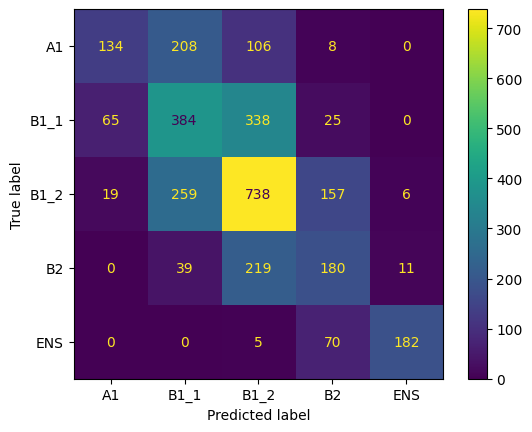

In [21]:
import math
import pandas as pd

nb_batches = math.ceil(len(raw_test_ds)/BATCH_SIZE)
y_preds = []

for i in range(nb_batches):
    input_texts = raw_test_ds[i * BATCH_SIZE: (i+1) * BATCH_SIZE]["text"]
    input_labels = raw_test_ds[i * BATCH_SIZE: (i+1) * BATCH_SIZE]["score"]
    encoded = tokenizer(input_texts, truncation=True, padding="max_length", max_length=256, return_tensors="pt").to("cuda")
    y_preds += model(**encoded).logits.reshape(-1).tolist()


df = pd.DataFrame([raw_test_ds["text"], raw_test_ds["score"], y_preds], ["Text", "Score", "Prediction"]).T
print(df)
df['Score'] = df['Score'].astype(int)
df['Prediction'] = df['Prediction'].astype('float')
df['Rounded'] = df['Prediction'].round()

confusion_matrix = metrics.confusion_matrix(df['Score'], df['Rounded'])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['A1', 'B1_1', 'B1_2', 'B2', 'ENS'])

cm_display.plot()
plt.show()

<br><br>
**<font size="4">Check Quadratic Weighted Kappa</font>**

<font size="4">And once again, QWK is near .68. Not great, but not bad.</font>
<br><br>

In [22]:
quadratic_weighted_kappa(df['Score'], df['Rounded'], 0, 6)

0.6801656978998348